In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%load_ext autoreload
%autoreload 2
from google.cloud import storage
import io
import librosa
import os
import sys
sys.path.append(os.path.abspath('../coughvid'))
from segmentation import segment_cough, compute_SNR
from scipy.io import wavfile
from IPython.display import Audio
sys.path.append(os.path.abspath('../coughvid'))
from feature_class import features
from DSP import classify_cough
import pickle
import librosa.display
import imageio

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# First Analysis

In [ ]:
df = pd.read_csv("../raw_data/metadata_compiled.csv",delimiter=',')
df.head()

In [ ]:
df['status'].value_counts()

In [ ]:
df['gender'].value_counts()

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
df.columns

In [ ]:
fill = df[['cough_detected','quality_1','cough_type_1', 'dyspnea_1', 'wheezing_1', 'stridor_1',
       'choking_1', 'congestion_1', 'nothing_1', 'diagnosis_1', 'severity_1']]

In [ ]:
fill['quality_1'].unique()

In [ ]:
df['quality_1'].value_counts()

In [ ]:
df['cough_type_1'].value_counts()

In [ ]:
df['dyspnea_1'].value_counts()

# Specific Investigation

## Considering only audios which have a status

In [ ]:
new_df = df[df['status'].notnull()].copy()
new_df


## Disconsidering the specialists features at first

In [ ]:
new_df.columns

In [ ]:
new_df = new_df[['uuid', 'datetime', 'cough_detected', 'SNR', 'latitude', 'longitude',
       'age', 'gender', 'respiratory_condition', 'fever_muscle_pain', 'status']].copy()
new_df

## Evaluating status

In [ ]:
new_df['status'].value_counts()/new_df['status'].count()

In [ ]:
new_df['status'].value_counts()

In [ ]:
1155+12479

## Removing Symptomatics

In [ ]:
new_df

In [ ]:
new_df = new_df[new_df['status'] != 'symptomatic'].copy()

In [ ]:
new_df['status'].value_counts()

## LabelEncoding features

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [ ]:
new_df.columns

In [ ]:
new_df['respiratory_condition'] = LabelEncoder().fit_transform(new_df['respiratory_condition'])
new_df['fever_muscle_pain'] = LabelEncoder().fit_transform(new_df['fever_muscle_pain'])
new_df['status'] = new_df['status'].map({'healthy': 0, 'COVID-19': 1})

Respiratory Condition and Fever Muscle Pain: 0 - False, 1 - True

Status: 0 - Healthy, 1 - COVID

In [ ]:
new_df.isnull().sum()

In [ ]:
new_df.isnull().sum() / new_df.count()

In [ ]:
new_df.describe()

## Imputing Age Mean

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
imputer = SimpleImputer(strategy="mean")
imputer.fit(new_df[['age']])
new_df['age'] = imputer.transform(new_df[['age']])

In [ ]:
new_df

## Defining Target and Features

In [ ]:
X = new_df.drop(columns=['uuid', 'datetime','SNR', 'latitude', 'longitude','gender','status'])
y = new_df['status']
X

In [ ]:
X.describe()

## Model Evaluation

In [ ]:
import statsmodels.formula.api as smf

In [ ]:
new_df

In [ ]:
model = smf.logit(formula='status ~ cough_detected + age + C(gender) + respiratory_condition + fever_muscle_pain - 1', data=new_df).fit()
model.summary()

# Cough Detection Threshold

In [ ]:
new_df = new_df[new_df['cough_detected']>0.6].copy()
new_df

In [ ]:
new_df.shape[0]

In [ ]:
threshold = 0.6

In [ ]:
new_df[new_df['cough_detected'] > threshold].shape[0]

# Cough Detection Model

In [ ]:
data_folder = '../sample_recordings'
loaded_model = pickle.load(open(os.path.join('../models', 'cough_classifier'), 'rb'))
loaded_scaler = pickle.load(open(os.path.join('../models','cough_classification_scaler'), 'rb'))

In [ ]:
filename = 'cough.wav'
x, fs = librosa.load(data_folder+'/'+filename, sr=None)
probability = classify_cough(x, fs, loaded_model, loaded_scaler)
print("The file {0} has a {1}\% probability of being a cough".format(filename,round(probability*100,2)))

In [ ]:
filename = 'not_cough.wav'
x, fs = librosa.load(data_folder+'/'+filename, sr=None)
probability = classify_cough(x, fs, loaded_model, loaded_scaler)
print("The file {0} has a {1}\% probability of being a cough".format(filename,round(probability*100,2)))

In [ ]:
client = storage.Client()
bucket = client.get_bucket('coughvid-650')
blob = bucket.get_blob('data/00039425-7f3a-42aa-ac13-834aaa2b6b92.wav')
audio,rate = librosa.load(io.BytesIO(blob.download_as_string()), sr=None)
probability = classify_cough(audio, rate, loaded_model, loaded_scaler)
print("The file {0} has a {1}\% probability of being a cough".format(filename,round(probability*100,2)))

In [ ]:
Audio(audio, rate=rate)

In [ ]:
rate

In [ ]:
df

# SNR Calculator

In [ ]:
client = storage.Client()

bucket = client.get_bucket('coughvid-650')

blob = bucket.get_blob('data/fff3ff61-2387-4139-938b-539db01e6be5.wav')

In [ ]:
audio,rate = librosa.load(io.BytesIO(blob.download_as_string()), sr=None)

In [ ]:
snr = compute_SNR(audio,rate)
print("The SNR of the cough signal is {0}".format(snr))

In [ ]:
df

In [ ]:
df.describe()

In [ ]:
Audio(audio, rate=rate)

# Mel Spectrogram

In [ ]:
client = storage.Client()
bucket = client.get_bucket('coughvid-650')
blob = bucket.get_blob('data/00039425-7f3a-42aa-ac13-834aaa2b6b92.wav')
audio,rate = librosa.load(io.BytesIO(blob.download_as_string()), sr=None)

In [ ]:
Audio(audio, rate=rate)

In [ ]:
# for i in range(len(audios_test)):
#     S = librosa.feature.melspectrogram(y = audios_test[i], sr = rates_test[i], n_mels=128, fmax=8000)
#     fig, ax = plt.subplots()
#     S_dB = librosa.power_to_db(S, ref=np.max)
#     img = librosa.display.specshow(S_dB, sr=rates_test[i], fmax=8000, ax=ax)
    
#     if new_df[new_df.index==index_test[i]].status.values[0] == 1:
#         plt.savefig('./test/2-COVID/' + f'test{i}.png')
#     else:
#         plt.savefig('./test/1-Healthy/' + f'test{i}.png')

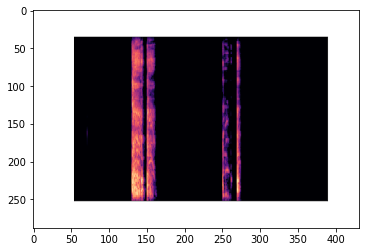

In [25]:
im = imageio.imread('./test/1-healthy/00039425-7f3a-42aa-ac13-834aaa2b6b92.png')
plt.imshow(im);

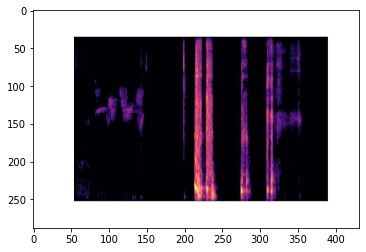

In [26]:
im = imageio.imread('./test/2-COVID/0b6c6e9b-7c10-4977-a281-f809b939c2e7.png')
plt.imshow(im);

# Image Model

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.preprocessing import image
from numpy import load
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import metrics

In [3]:
X = load('./sample/sample.npy')
y= load('./sample/sample_target.npy')

In [4]:
X.shape

(1512, 288, 432, 4)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [14]:
def initialize_model():
    model = models.Sequential()

    #first_convolution
    model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(288, 432, 4)))
    model.add(layers.MaxPooling2D(2, 2))
    #second_convolution
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    #third_convolution
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    #fourth_convolution
    #     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    #     tf.keras.layers.MaxPooling2D(2,2),
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy',metrics.Recall()])
    
    return model

model = initialize_model()

In [15]:
model.fit(X_train,y_train, batch_size=32,epochs=50)

2021-08-06 15:51:08.559744: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 526528512 exceeds 10% of free system memory.
2021-08-06 15:51:08.853296: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-06 15:51:08.853732: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3792885000 Hz


Epoch 1/50
 1/34 [..............................] - ETA: 2:53 - loss: 10.0084 - accuracy: 0.5625 - recall_2: 0.7000

KeyboardInterrupt: 

# Try

In [ ]:
new_df.shape

In [ ]:
new_df[new_df.index==16330]

In [ ]:
df[df.index==11501].status

In [ ]:
df.status.value_counts()

In [ ]:
new_df

In [ ]:
# for i in range(len(audios_test)):
#     S = librosa.feature.melspectrogram(y = audios_test[i], sr = rates_test[i], n_mels=128, fmax=8000)
#     fig, ax = plt.subplots()
#     S_dB = librosa.power_to_db(S, ref=np.max)
#     img = librosa.display.specshow(S_dB, sr=rates_test[i], fmax=8000, ax=ax)
    
#     if new_df[new_df.index==index_test[i]].status.values[0] == 1:
#         plt.savefig('./test/2-COVID/' + f'test{i}.png')
#     else:
#         plt.savefig('./test/1-Healthy/' + f'test{i}.png')

In [ ]:
path_dir = './test2/'

In [ ]:
datagen = ImageDataGenerator(
                    rescale=1./255,
                    validation_split = 0.2)
train_generator = datagen.flow_from_directory(
    path_dir,
    target_size=(288, 432,4),
    shuffle=True,
    subset='training'
)
validation_generator = datagen.flow_from_directory(
    path_dir,
    target_size=(288, 432,4),
    subset='validation'
)

In [ ]:
pd.DataFrame(train_generator.labels).value_counts()

In [ ]:
pd.DataFrame(validation_generator.labels).value_counts()

In [ ]:
validation_generator.image_shape

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = tf.keras.metrics.Recall())
model.fit(train_generator, batch_size=32,epochs=50)

In [ ]:
accuracy = model.evaluate(validation_generator)
print('n', 'Test_Accuracy:-', accuracy[1])
pred = model.predict(validation_generator)
y_pred = np.argmax(pred, axis=1)
y_true = validation_generator.labels
print('confusion matrix')
print(confusion_matrix(y_true, y_pred))
    #confusion matrix
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
import joblib
joblib.dump(model, 'model.joblib')

In [ ]:
new_df.shape

In [ ]:
def get_all_audios(df, start = 0, finish = 10):

    client = storage.Client()

    bucket = client.get_bucket('coughvid-650')
    
    files = df.uuid.iloc[start:finish]
    
    rates = []
    
    audios = []
    
    print("Good luck!")
    
    j=0
    for i in files:
    
        blob = bucket.get_blob('data/' + f'{i}' + '.wav')
        
        print('getting ' + f'{j} - {i}' + '.wav' + '...')
        
        audio, rate = librosa.load(io.BytesIO(blob.download_as_string()), sr=None)
        
        rates.append(rate)
        
        audios.append(audio)
        j += 1
    print("Done!")
    
    return rates, audios, files.index.values

In [ ]:
def audios_to_images(df, audios, rates, index, sub_folders = ['COVID', 'Healthy']):
    import os
    for folder in range(len(sub_folders)):
        if os.path.isdir(f'{sub_folders[folder]}'):
            continue
        else:
            os.mkdir(f'{sub_folders[folder]}')
    j=0
    for i in range(len(audios)):
        S = librosa.feature.melspectrogram(y = audios[i], sr = rates[i], n_mels=128, fmax=8000)
        fig, ax = plt.subplots()
        S_dB = librosa.power_to_db(S, ref=np.max)
        img = librosa.display.specshow(S_dB, sr=rates[i], fmax=8000, ax=ax)
        
        print(f'Fetching {j}')
        j += 1
        if df[df.index==index[i]].status.values[0] == 1:
            plt.savefig(f'./{sub_folders[0]}/' + f'{df.uuid[df.index==index[i]].values[0]}.png')
        else:
            plt.savefig(f'./{sub_folders[1]}/' + f'{df.uuid[df.index==index[i]].values[0]}.png')
        plt.close()
    return print('Done!')


In [ ]:
# rate_info, audio_info, index_info = get_all_audios(new_df,3142,5191)

In [ ]:
# audios_to_images(new_df,audio_info,rate_info,index_info)

In [6]:
# load numpy array from npy file
from numpy import load
# load array
X = load('data.npy')
X.shape

(10191, 288, 432, 4)

In [5]:
# load numpy array from npy file
from numpy import load
# load array
y = load('target.npy')
y.shape

(10191,)

In [3]:
import matplotlib.pyplot as plt
plt.imshow(X[0])

NameError: name 'X' is not defined

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [8]:
X_train.shape

(7133, 288, 432, 4)

In [9]:
X_test.shape

(3058, 288, 432, 4)

In [10]:
import pandas as pd
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import metrics
from sklearn.metrics import confusion_matrix

2021-08-06 10:52:09.402697: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-06 10:52:09.402774: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [45]:
import numpy as np
import pandas as pd
import os
import subprocess
subprocess.call(["ffmpeg", "-i","./WhatsApp Ptt 2021-08-09 at 13.32.27.ogg", "./WhatsApp Ptt 2021-08-09 at 13.32.27.wav"])

ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

0

In [46]:
test = "UploadedFile(id=17, name='WhatsApp Ptt 2021-08-09 at 13.32.27.wav', type='audio/wav', size=387294)"

In [78]:
test.find("name=")

20

In [84]:
test2 = test[test.find("name=")+6:test.find("type=")-3]
test2

'WhatsApp Ptt 2021-08-09 at 13.32.27.wav'